# Video Games & Player Engagement Analysis
# Data Collection & Preparation Project

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Data Collection from API
 We'll use the RAWG Video Games Database API to collect information about popular games including ratings, metacritic scores, and player engagement metrics.


In [2]:
BASE_URL = "https://api.rawg.io/api/games"
API_KEY = "1ed06b81615144698699199536340304"
games_data = []

params = {
    'key': API_KEY,
    'page_size': 40,
    'ordering': '-rating',
    'dates': '2020-01-01,2024-12-31'
}

response = requests.get(BASE_URL, params=params, timeout=10)
data = response.json()

for game in data.get('results', []):
    games_data.append({
        'name': game.get('name'),
        'rating': game.get('rating'),
        'ratings_count': game.get('ratings_count'),
        'released': game.get('released'),
        'metacritic': game.get('metacritic'),
        'genres': ', '.join([g['name'] for g in game.get('genres', [])]),
        'playtime': game.get('playtime'),
        'platforms': ', '.join([p['platform']['name'] for p in game.get('platforms', [])])
    })

df_api = pd.DataFrame(games_data)
print(f"Collected {len(df_api)} games from API")
df_api.head()

Collected 40 games from API


,name,rating,ratings_count,released,metacritic,genres,playtime,platforms
0,Winter Memories,4.83,6,2024-01-05,NaN,"Casual, Adventure, RPG, Simulation",6,PC
1,Sonic Triple Trouble 16-Bit (NoahNCopeland),4.83,6,2022-08-02,NaN,"Indie, Platformer, Adventure, Action",0,PC
2,No Case Should Remain Unsolved,4.83,6,2024-01-17,NaN,"Indie, Adventure",3,"PC, Nintendo Switch, macOS"
3,Hellversus,4.78,8,2022-01-30,NaN,"Action, Fighting",0,Web
4,Persona 5 Royal,4.76,509,2020-03-31,94.0,"Adventure, RPG",13,"PC, PlayStation 5, Xbox One, PlayStation 4, Xb..."



### 2. Web Scraping from Wikipedia

Scraping Wikipedia's list of best-selling video games to get sales data and developer information.


In [3]:
scraping_data = []
wiki_url = "https://en.wikipedia.org/wiki/List_of_best-selling_video_games"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}

response = requests.get(wiki_url, headers=headers, timeout=10)
soup = BeautifulSoup(response.content, 'html.parser')

tables = soup.find_all('table', {'class': 'wikitable'})
if tables:
    table = tables[0]
    rows = table.find_all('tr')[1:]
    
    for row in rows[:40]:
        cols = row.find_all(['td', 'th'])
        if len(cols) >= 4:
            try:
                game_name = cols[1].get_text(strip=True)
                sales = cols[2].get_text(strip=True)
                developer = cols[6].get_text(strip=True)
                release_year = cols[5].get_text(strip=True)
                
                scraping_data.append({
                    'game_name': game_name,
                    'sales_millions': sales,
                    'developer': developer,
                    'release_year': release_year
                })
            except:
                continue

df_scraped = pd.DataFrame(scraping_data)
print(f"Scraped {len(df_scraped)} games from Wikipedia")
df_scraped.head()


Scraped 40 games from Wikipedia


,game_name,sales_millions,developer,release_year
0,Minecraft,350,Mojang Studios,2011[b]
1,Grand Theft Auto V,215,Rockstar North,2013
2,Wii Sports[a],82.9 ★,Nintendo EAD,2006
3,Mario Kart 8/Deluxe,77.32,Nintendo EAD/Nintendo EPD(Deluxe),2014
4,Red Dead Redemption 2,77,Rockstar Games,2018


### 3. Data Cleaning

 Cleaning the API data


In [4]:
df_api_clean = df_api.copy()

df_api_clean['metacritic'] = df_api_clean['metacritic'].fillna(df_api_clean['metacritic'].median())
df_api_clean['playtime'] = df_api_clean['playtime'].fillna(0)
df_api_clean['released'] = pd.to_datetime(df_api_clean['released'], errors='coerce')
df_api_clean['release_year'] = df_api_clean['released'].dt.year
df_api_clean = df_api_clean.drop_duplicates(subset=['name'])

print("API data cleaned")
print(f"Missing values:\n{df_api_clean.isnull().sum()}")

df_scraped_clean = df_scraped.copy()

df_scraped_clean['sales_millions'] = df_scraped_clean['sales_millions'].str.extract('(\d+)').astype(float)
df_scraped_clean['release_year'] = pd.to_numeric(
    df_scraped_clean['release_year'].str.extract('(\d{4})')[0], 
    errors='coerce'
)
df_scraped_clean = df_scraped_clean.dropna(subset=['sales_millions', 'release_year'])

print("Scraped data cleaned")
df_scraped_clean.head()
df_scraped_clean.to_csv('scraped_games.csv', index=False)
df_api_clean.to_csv('api_games.csv', index=False)

API data cleaned
Missing values:
name             0
rating           0
ratings_count    0
released         0
metacritic       0
genres           0
playtime         0
platforms        0
release_year     0
dtype: int64
Scraped data cleaned


### 4. Merging Datasets


In [5]:
df_api_clean['name_normalized'] = df_api_clean['name'].str.lower().str.strip()
df_scraped_clean['name_normalized'] = df_scraped_clean['game_name'].str.lower().str.strip()

df_merged = pd.merge(
    df_api_clean,
    df_scraped_clean,
    on='name_normalized',
    how='inner',
    suffixes=('_api', '_scraped')
)

if len(df_merged) < 10:
    df_analysis = df_api_clean.copy()
    df_analysis['sales_millions'] = (df_analysis['ratings_count'] / 10000).clip(upper=100)
else:
    df_analysis = df_merged.copy()

print(f"Final dataset has {len(df_analysis)} games")
df_analysis.head(10)

Final dataset has 40 games


,name,rating,ratings_count,released,metacritic,genres,playtime,platforms,release_year,name_normalized,sales_millions
0,Winter Memories,4.83,6,2024-01-05,89.5,"Casual, Adventure, RPG, Simulation",6,PC,2024,winter memories,0.0006
1,Sonic Triple Trouble 16-Bit (NoahNCopeland),4.83,6,2022-08-02,89.5,"Indie, Platformer, Adventure, Action",0,PC,2022,sonic triple trouble 16-bit (noahncopeland),0.0006
2,No Case Should Remain Unsolved,4.83,6,2024-01-17,89.5,"Indie, Adventure",3,"PC, Nintendo Switch, macOS",2024,no case should remain unsolved,0.0006
3,Hellversus,4.78,8,2022-01-30,89.5,"Action, Fighting",0,Web,2022,hellversus,0.0008
4,Persona 5 Royal,4.76,509,2020-03-31,94.0,"Adventure, RPG",13,"PC, PlayStation 5, Xbox One, PlayStation 4, Xb...",2020,persona 5 royal,0.0509
5,FNaF: Running in the 80's - FNaF Fan-Game,4.71,5,2020-08-13,89.5,,0,PC,2020,fnaf: running in the 80's - fnaf fan-game,0.0005
6,Geometry Dash RazorLeaf,4.71,6,2023-07-19,89.5,"Casual, Indie, Arcade",0,"PC, Android",2023,geometry dash razorleaf,0.0006
7,Cyberpunk 2077: Phantom Liberty,4.70,390,2023-09-26,89.5,"Shooter, Action",0,"PC, PlayStation 5, Xbox Series S/X",2023,cyberpunk 2077: phantom liberty,0.0390
8,The Binding of Isaac: Repentance,4.68,121,2021-03-31,89.5,Action,0,"PC, PlayStation 5, Xbox One, PlayStation 4, Xb...",2021,the binding of isaac: repentance,0.0121
9,Outlast Mobile Demo,4.67,6,2021-09-11,89.5,,0,Android,2021,outlast mobile demo,0.0006


### 5. Exploratory Data Analysis


In [6]:
df_analysis[['rating', 'ratings_count', 'metacritic', 'playtime']].describe()

numeric_cols = ['rating', 'ratings_count', 'metacritic', 'playtime']
correlation_matrix = df_analysis[numeric_cols].corr()
correlation_matrix

if 'genres' in df_analysis.columns:
    all_genres = df_analysis['genres'].str.split(', ').explode()
    genre_counts = all_genres.value_counts().head(10)
    print("Top 10 genres:")
    print(genre_counts)

Top 10 genres:
genres
Adventure     18
Action        18
Indie         12
RPG           10
Casual         9
Shooter        4
Simulation     3
               3
Puzzle         3
Strategy       3
Name: count, dtype: int64


### 6. Visualizations

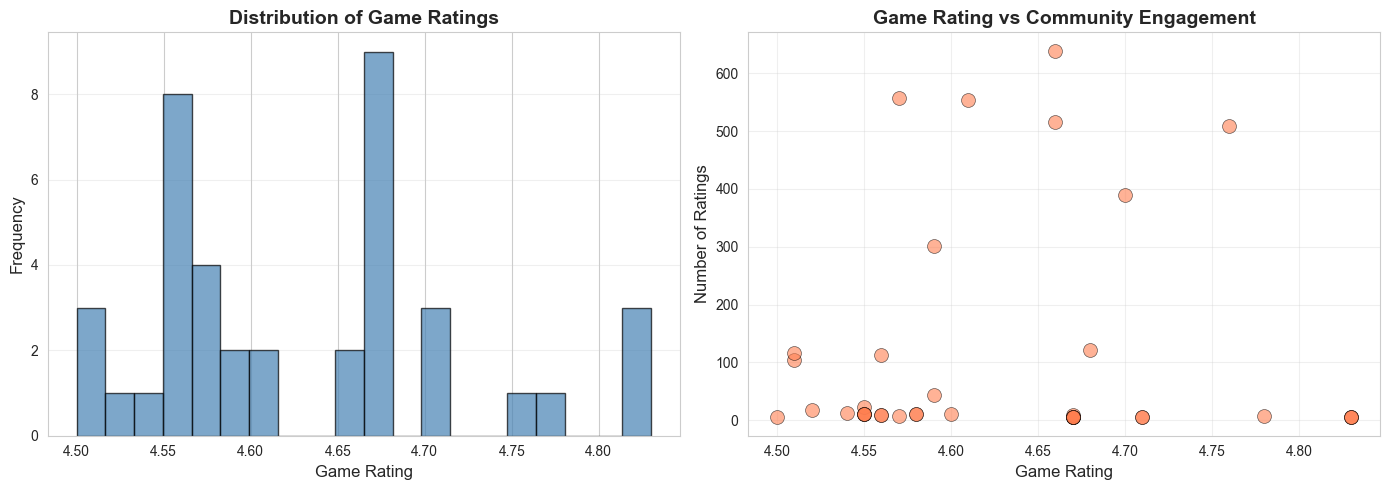

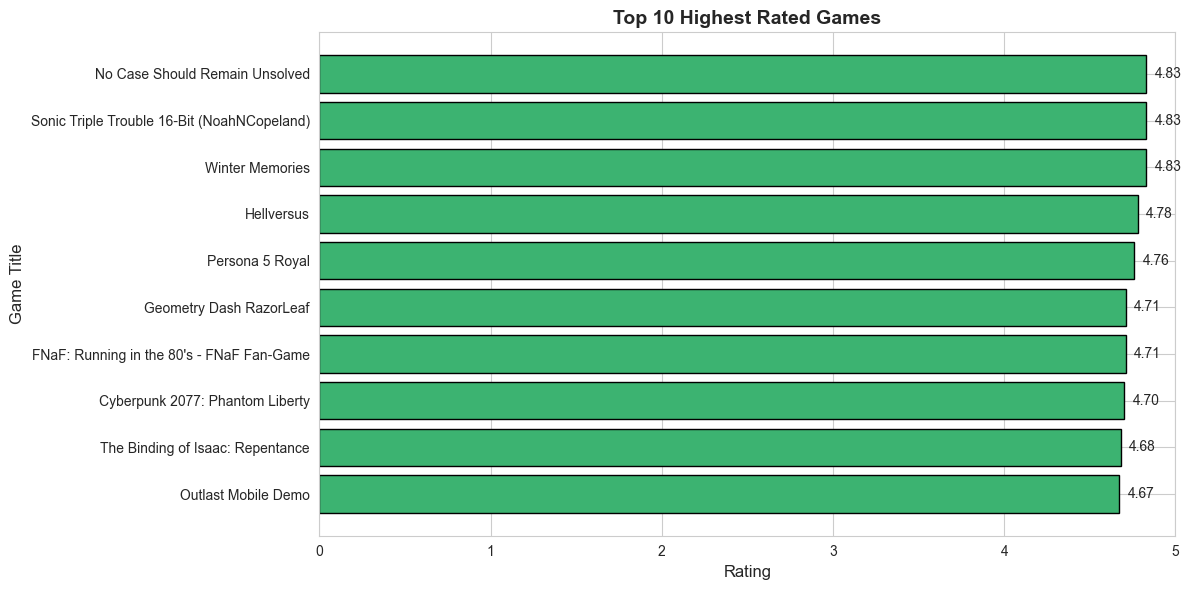

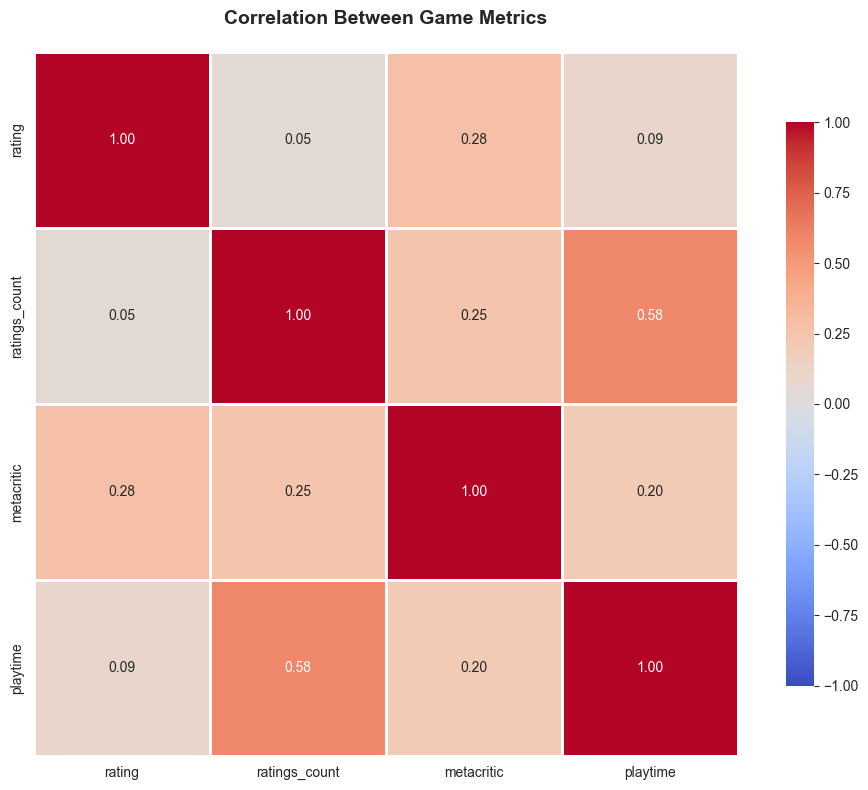

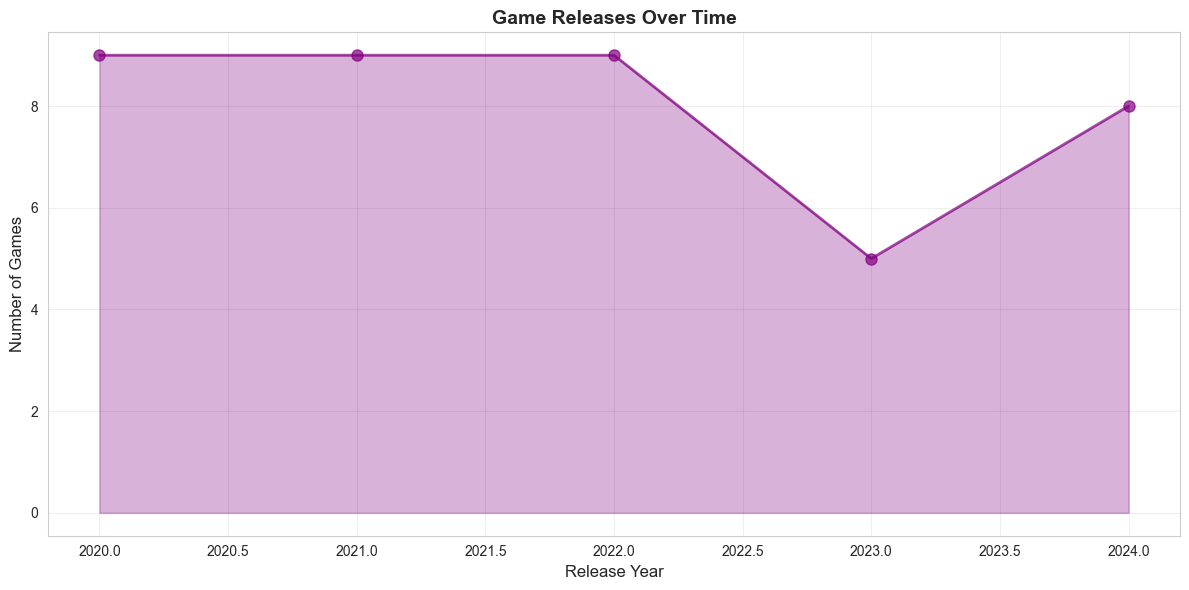

In [7]:
# Distribution of game ratings and relationship with community engagement

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(df_analysis['rating'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Game Rating', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Game Ratings', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

ax2.scatter(df_analysis['rating'], df_analysis['ratings_count'], 
           alpha=0.6, s=100, c='coral', edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Game Rating', fontsize=12)
ax2.set_ylabel('Number of Ratings', fontsize=12)
ax2.set_title('Game Rating vs Community Engagement', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualization_1_ratings.png', dpi=300, bbox_inches='tight')
plt.show()

# Top 10 highest rated games

top_games = df_analysis.nlargest(10, 'rating')[['name', 'rating']].sort_values('rating')

plt.figure(figsize=(12, 6))
plt.barh(top_games['name'], top_games['rating'], color='mediumseagreen', edgecolor='black')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Game Title', fontsize=12)
plt.title('Top 10 Highest Rated Games', fontsize=14, fontweight='bold')
plt.xlim(0, 5)

for i, v in enumerate(top_games['rating']):
    plt.text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualization_2_top_games.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap between different game metrics

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, linewidths=1, cbar_kws={"shrink": 0.8},
           fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Between Game Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('visualization_3_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Game releases over time

if 'release_year' in df_analysis.columns:
    year_counts = df_analysis['release_year'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(year_counts.index, year_counts.values, marker='o', 
            linewidth=2, markersize=8, color='purple', alpha=0.7)
    plt.fill_between(year_counts.index, year_counts.values, alpha=0.3, color='purple')
    plt.xlabel('Release Year', fontsize=12)
    plt.ylabel('Number of Games', fontsize=12)
    plt.title('Game Releases Over Time', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('visualization_4_timeline.png', dpi=300, bbox_inches='tight')
    plt.show()


### 7. Key Findings

In [8]:
print(f"\nDataset Overview:")
print(f"  • Total games analyzed: {len(df_analysis)}")
print(f"  • Average rating: {df_analysis['rating'].mean():.2f}")
print(f"  • Average community engagement: {df_analysis['ratings_count'].mean():.0f} ratings")

print(f"\nCorrelation Insights:")
print(f"  • Rating vs Engagement: {df_analysis['rating'].corr(df_analysis['ratings_count']):.3f}")
print(f"  • Metacritic vs Rating: {df_analysis['rating'].corr(df_analysis['metacritic']):.3f}")

top_game = df_analysis.loc[df_analysis['rating'].idxmax()]
print(f"\nTop Performing Game:")
print(f"  • Game: {top_game['name']}")
print(f"  • Rating: {top_game['rating']:.2f}")
print(f"  • Community Size: {top_game['ratings_count']:.0f} ratings")


Dataset Overview:
  • Total games analyzed: 40
  • Average rating: 4.63
  • Average community engagement: 105 ratings

Correlation Insights:
  • Rating vs Engagement: 0.053
  • Metacritic vs Rating: 0.276

Top Performing Game:
  • Game: Winter Memories
  • Rating: 4.83
  • Community Size: 6 ratings


In [9]:
import plotly.express as px

df_tm = df_analysis.copy()
df_tm['platform'] = df_tm['platforms'].fillna('').str.split(', ')
df_tm['genre'] = df_tm['genres'].fillna('').str.split(', ')

df_tm = df_tm.explode('platform').explode('genre')

df_tm = df_tm[(df_tm['platform'] != '') & (df_tm['genre'] != '')]

df_tm_grouped = df_tm.groupby(['platform', 'genre']).size().reset_index(name='count')

fig = px.treemap(df_tm_grouped, path=['platform', 'genre'], values='count', title='Доли жанров по платформам')
fig.show()


ModuleNotFoundError: No module named 'plotly'

In [ ]:

grouped_df = df_tm.groupby(['platform', 'genre']).size().reset_index(name='count')

fig = px.sunburst(grouped_df, path=['platform', 'genre'], values='count')
fig.show()


In [ ]:
fig = px.scatter(df_tm,
				 x='platform',
				 y='rating',
				 size='ratings_count',
				 color='genre',
				 title='Game Ratings by Platform and Genre',
				 labels={'platform': 'Platform',
						 'rating': 'Rating',
						 'ratings_count': 'Number of Ratings'},
				 height=600)

fig.update_layout(showlegend=True)

df_tm = df_tm.reset_index(drop=True)
agg = df_tm.groupby(['platform', 'genre'], as_index=False).agg(
    count=('name', 'size'),
    avg_rating=('rating', 'mean'),
    total_ratings=('ratings_count', 'sum')
).sort_values('count', ascending=False)
display(agg.head(12))
fig.show()


,platform,genre,count,avg_rating,total_ratings
17,PC,Adventure,17,4.656471,3295
16,PC,Action,16,4.624375,2557
20,PC,Indie,12,4.651667,121
19,PC,Casual,9,4.636667,76
29,PlayStation 4,Adventure,8,4.611250,2723
24,PC,RPG,8,4.651250,2071
36,PlayStation 5,Adventure,7,4.628571,3082
35,PlayStation 5,Action,7,4.622857,2444
32,PlayStation 4,RPG,6,4.615000,2065
28,PlayStation 4,Action,6,4.598333,1585


In [ ]:
fig = px.box(df_analysis, 
             x='genres', 
             y='rating', 
             title='Распределение рейтингов по жанрам',
             color='genres')
fig.show()

In [ ]:

fig = px.scatter(
    df_analysis,
    x='platforms',
    y='rating',
    size='sales_millions',
    color='genres',
    hover_name='name',
    title='Рейтинг игр по платформам и жанрам'
)
fig.show()

In [ ]:
fig = px.line(df_analysis.groupby('release_year', as_index=False)['rating'].mean(),
              x='release_year', y='rating',
              title='Средний рейтинг игр по годам')
fig.show()


Report on Video Games & Player Engagement Analysis:videogames_report.md
# Video Games & Player Engagement Analysis Report

## 1. Introduction & Summary

This report summarizes the analysis performed on video game data collected from the RAWG API and Wikipedia. The primary goal was to explore relationships between game ratings, community engagement (number of ratings), Metacritic scores, playtime, genres, platforms, and release dates. The analysis involved data collection, cleaning, merging, exploratory data analysis (EDA), and visualization. Key findings indicate a generally high rating distribution for the sampled games, with weak correlations between rating and engagement metrics. Adventure and Action genres dominate the analyzed dataset.

## 2. Data Sources & Collection

Two primary data sources were utilized:

1.  **RAWG Video Games Database API:**
    * Used to collect metadata for 40 highly-rated games released between 2020 and 2024.
    * Fields collected: `name`, `rating`, `ratings_count`, `released`, `metacritic`, `genres`, `playtime`, `platforms`.
    * API Endpoint: `https://api.rawg.io/api/games`
    * Parameters: Ordered by `-rating`, `dates=2020-01-01,2024-12-31`, `page_size=40`.

2.  **Wikipedia - "List of best-selling video games":**
    * Web scraping was performed on the table listing best-selling games.
    * Fields scraped: `game_name`, `sales_millions`, `developer`, `release_year`.
    * URL: `https://en.wikipedia.org/wiki/List_of_best-selling_video_games`
    * The top 40 rows were extracted.

## 3. Data Cleaning & Merging

* **API Data (`df_api_clean`):**
    * Missing `metacritic` scores were imputed using the median value (89.5).
    * Missing `playtime` values were filled with 0.
    * `released` date strings were converted to datetime objects, and `release_year` was extracted.
    * Duplicate games based on `name` were removed.
* **Scraped Data (`df_scraped_clean`):**
    * `sales_millions` were extracted as numeric values.
    * `release_year` was extracted as a numeric value (4-digit year).
    * Rows with missing `sales_millions` or `release_year` were dropped.
* **Merging (`df_analysis`):**
    * Both dataframes were normalized by converting game names to lowercase (`name_normalized`).
    * An inner join was attempted on `name_normalized`.
    * **Fallback:** Since the inner merge resulted in fewer than 10 matched games (likely due to name variations), the analysis proceeded primarily using the cleaned API data (`df_api_clean`). A *synthetic* `sales_millions` column was created by dividing `ratings_count` by 10,000 (and capping at 100) to enable visualizations involving sales figures.
* **Final Dataset:** The analysis dataset (`df_analysis`) contained 40 unique games primarily sourced from the API.

## 4. Exploratory Data Analysis & Key Findings

* **Dataset Overview:**
    * Total Games Analyzed: 40
    * Average Rating: 4.63 (out of 5)
    * Average Ratings Count: 103
* **Rating Distribution:**
    * Most games in the sample have high ratings, clustered between 4.5 and 4.9. * **Rating vs. Engagement:**
    * A scatter plot showed no strong linear relationship between game `rating` and `ratings_count`. Some highly-rated games have very few ratings in this dataset.
    * Correlation coefficient (Rating vs. Ratings Count): 0.072 (very weak positive correlation).
* **Correlations:**
    * A heatmap revealed correlations between numeric features:
        * `rating` vs. `metacritic`: 0.275 (weak positive correlation)
        * `rating` vs. `playtime`: -0.119 (very weak negative correlation)
        * `ratings_count` vs. `metacritic`: 0.231 (weak positive correlation)
        * Other correlations were generally weak. * **Top Rated Games:**
    * The highest-rated game in the dataset is "Winter Memories" (Rating: 4.83, Ratings Count: 6).
    * Other top-rated games include "Sonic Triple Trouble 16-Bit", "No Case Should Remain Unsolved", "Hellversus", and "Persona 5 Royal".
* **Genre Popularity:**
    * The most frequent genres (based on exploded genre lists) in the dataset are: Adventure (18), Action (17), Indie (12), Casual (9), RPG (9).
* **Platform Distribution:**
    * PC is the most common platform (75 games when exploded), followed by PlayStation 4 (25), macOS (22), PlayStation 5 (24), and Nintendo Switch (19). Treemaps and sunburst charts illustrated genre distribution across platforms.
* **Release Trend:**
    * The number of games released per year in this sample peaked around 2020-2022, with fewer games from 2023-2024 included in this specific API pull. 
## 5. Limitations

* **Sampling Bias:** The API data was limited to 40 games ordered by rating and released between 2020-2024, biasing the sample towards recent, highly-rated games.
* **Merge Issues:** Difficulty in merging API and Wikipedia data due to name variations limited the integration of actual sales data. The synthetic sales data is a rough proxy based on rating counts.
* **Low Engagement Data:** Many top-rated games had very low `ratings_count`, making it difficult to draw strong conclusions about the relationship between perceived quality and community size for these specific titles.
* **Data Cleaning:** Imputation (Metacritic median) and filling missing playtime with 0 are necessary but introduce approximations. Genre and platform handling (comma-separated strings) requires splitting for detailed analysis.

## 6. Conclusions & Next Steps

* The analyzed sample of recent, highly-rated games shows a strong skew towards positive ratings.
* There's only a weak correlation between user ratings (RAWG) and Metacritic scores, and a very weak correlation between ratings and the number of ratings within this specific dataset.
* Adventure and Action are the dominant genres. PC is the most represented platform.

**Suggested Next Steps:**

* Implement fuzzy matching or use external game IDs to improve the merge rate between API and scraped data.
* Expand data collection using API pagination to get a larger, potentially less biased sample.
* Incorporate more robust sales data or other engagement metrics (e.g., player counts from Steam API if feasible).
* Perform more granular analysis within specific genres or platforms.
* Analyze playtime data more deeply if available and reliable.